**Unicorn Investors are considering making an investment in a new form of transportation - JetRail. 
JetRail uses Jet propulsion technology to run rails and move people at a high speed! 
While JetRail has mastered the technology and they hold the patent for their product, 
the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old 
looking for pre-series A funding. In order to help Unicorn Ventures in their decision, 
you need to forecast the traffic on JetRail for the next 7 months. 
You are provided with traffic data of JetRail since inception in the test file.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_style('whitegrid')

In [4]:
df = pd.read_csv('Train_SU63ISt.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
#Datetime is just an Id, lets make it index
df.set_index('Datetime', inplace=True)

In [6]:
df.head()

,ID,Count
Datetime,,
25-08-2012 00:00,0,8
25-08-2012 01:00,1,2
25-08-2012 02:00,2,6
25-08-2012 03:00,3,2
25-08-2012 04:00,4,2


In [7]:
#lets drop ID column
#df.drop('ID', axis=1, inplace=True)

In [8]:
df.head()

,ID,Count
Datetime,,
25-08-2012 00:00,0,8
25-08-2012 01:00,1,2
25-08-2012 02:00,2,6
25-08-2012 03:00,3,2
25-08-2012 04:00,4,2


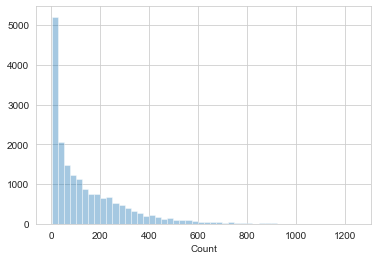

In [9]:
#lets see distribution
sns.distplot(df['Count'], kde=False)
#it is not gaussian distribution. Lets try transformation

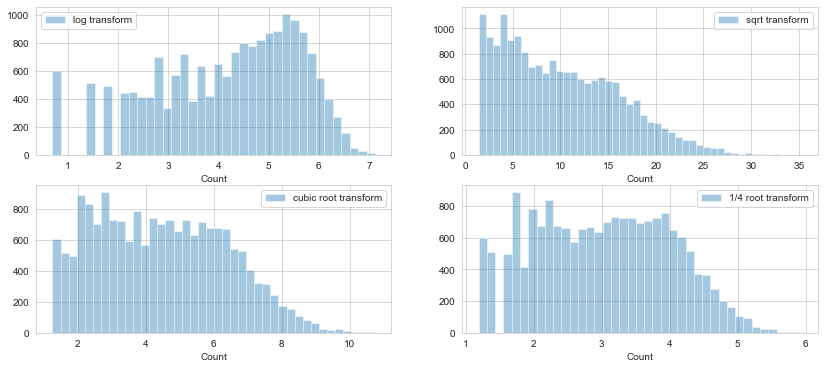

In [10]:
# Creates four axes, and accesses them through the returned array
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,6))
sns.distplot(np.log(df['Count']), kde=False, ax = axes [0,0], label='log transform')
sns.distplot(((df['Count'])**(1/2)), kde=False, ax = axes [0,1], label='sqrt transform')
sns.distplot(((df['Count'])**(1/3)), kde=False, ax = axes [1,0], label='cubic root transform')
sns.distplot(((df['Count'])**(1/4)), kde=False, ax = axes [1,1], label='1/4 root transform')
axes [0,0].legend()
axes [0,1].legend()
axes [1,0].legend()
axes [1,1].legend()

In [11]:
df.info()#18288 hours

<class 'pandas.core.frame.DataFrame'>
Index: 18288 entries, 25-08-2012 00:00 to 25-09-2014 23:00
Data columns (total 2 columns):
ID       18288 non-null int64
Count    18288 non-null int64
dtypes: int64(2)
memory usage: 428.6+ KB


In [12]:
df.describe()

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


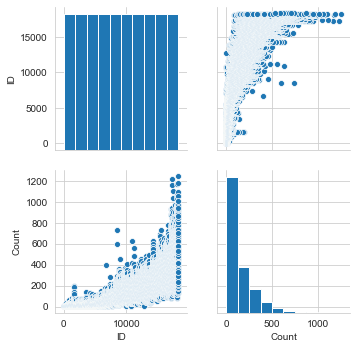

In [13]:
sns.pairplot(df)

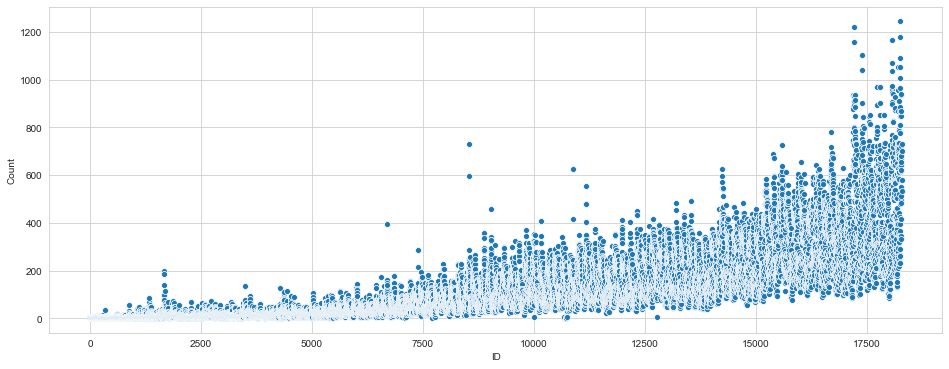

In [14]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='ID', y='Count', data=df)
#this shows increasing trends

In [15]:
df.head()

,ID,Count
Datetime,,
25-08-2012 00:00,0,8
25-08-2012 01:00,1,2
25-08-2012 02:00,2,6
25-08-2012 03:00,3,2
25-08-2012 04:00,4,2


In [16]:
#df.drop('ID', axis=1, inplace=True)

<Figure size 864x432 with 0 Axes>

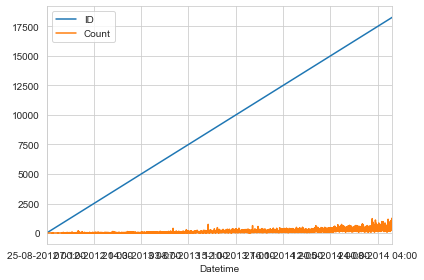

In [17]:
# line plot
plt.figure(figsize=(12,6))
df.plot()
plt.tight_layout()

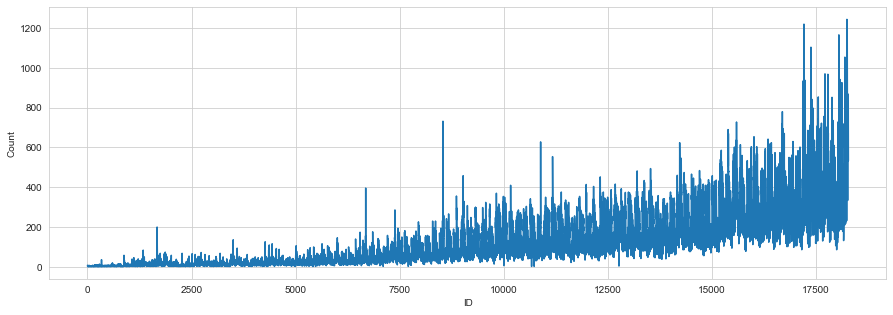

In [18]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ID', y='Count', data=df)
#Increasing trend: we have to transform it to stationary

In [19]:
df.tail()

,ID,Count
Datetime,,
25-09-2014 19:00,18283,868
25-09-2014 20:00,18284,732
25-09-2014 21:00,18285,702
25-09-2014 22:00,18286,580
25-09-2014 23:00,18287,534


In [20]:
df = df.reset_index()
df.drop('Datetime', axis=1, inplace=True)

In [21]:
df.drop('ID', axis=1, inplace=True)

In [22]:
# To remove Trends and to make data stationary: Difference transform - create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.DataFrame(diff)

In [23]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [24]:
#df.info()

In [25]:
df.values[1]

array([2], dtype=int64)

In [26]:
for i in range(5):
    print(i)

0
1
2
3
4


In [27]:
# transform to be stationary
diff_values = difference(df.values, 1)
diff_values.head()
print(len(diff_values)) #notice 1 value gone

18287


In [28]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
print(type(diff_values))
print(diff_values.head())
print(diff_values.shape)

<class 'pandas.core.frame.DataFrame'>
   0
0 -6
1  4
2 -4
3  0
4  0
(18287, 1)


In [30]:
#prepare supervised data
df_supervised_data = series_to_supervised(diff_values.values, n_in=4, n_out=1)
#df_supervised_data

In [31]:
df_supervised_data.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
4,-6.0,4.0,-4.0,0.0,0
5,4.0,-4.0,0.0,0.0,0
6,-4.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,4
8,0.0,0.0,0.0,4.0,-4


In [32]:
#df_supervised_data = df_supervised_data.astype('int64')
df_supervised_data = df_supervised_data.astype('float')

In [33]:
df_supervised_data.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
4,-6.0,4.0,-4.0,0.0,0.0
5,4.0,-4.0,0.0,0.0,0.0
6,-4.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,4.0
8,0.0,0.0,0.0,4.0,-4.0


In [34]:
df_supervised_data.shape #18281*8

(18283, 5)

In [35]:
total = df_supervised_data.shape[0]
test_size = 0.3 #30% and 70%train

start_train_index = 0
end_train_index = int(np.ceil(total*0.7))
start_test_index = end_train_index+1
end_test_index = total-1

In [36]:
print('train range:',(start_train_index, end_train_index), '; test range',(start_test_index, end_test_index))

train range: (0, 12799) ; test range (12800, 18282)


In [37]:
df_supervised_data = df_supervised_data.reset_index()
df_supervised_data.drop('index', axis=1, inplace=True)
df_supervised_data.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,-6.0,4.0,-4.0,0.0,0.0
1,4.0,-4.0,0.0,0.0,0.0
2,-4.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0
4,0.0,0.0,0.0,4.0,-4.0


In [38]:
df_supervised_train_data = df_supervised_data.iloc[start_train_index:end_train_index+1]
df_supervised_test_data = df_supervised_data.iloc[start_test_index:end_test_index+1]

In [39]:
df_supervised_train_data.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,-6.0,4.0,-4.0,0.0,0.0
1,4.0,-4.0,0.0,0.0,0.0
2,-4.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0
4,0.0,0.0,0.0,4.0,-4.0


In [40]:
df_supervised_test_data.tail()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
18278,70.0,-32.0,-32.0,58.0,188.0
18279,-32.0,-32.0,58.0,188.0,-136.0
18280,-32.0,58.0,188.0,-136.0,-30.0
18281,58.0,188.0,-136.0,-30.0,-122.0
18282,188.0,-136.0,-30.0,-122.0,-46.0


In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler_output = MinMaxScaler(feature_range=(0,1))

In [43]:
#df_supervised_train_data = scaler.fit_transform(df_supervised_train_data)

#df_supervised_test_data = scaler.transform(df_supervised_test_data)

In [44]:
df_supervised_train_data_X = df_supervised_train_data.drop('var1(t)', axis=1)
df_supervised_train_data_Y = df_supervised_train_data['var1(t)']

df_supervised_test_data_X = df_supervised_test_data.drop('var1(t)', axis=1)
df_supervised_test_data_Y = df_supervised_test_data['var1(t)']

In [45]:
df_supervised_train_data_X_scaled = scaler.fit_transform(df_supervised_train_data_X)
df_supervised_test_data_X_scaled = scaler.transform(df_supervised_test_data_X)

df_supervised_train_data_Y_scaled = scaler_output.fit_transform(df_supervised_train_data_Y.values.reshape(-1,1))
df_supervised_test_data_Y_scaled = scaler_output.transform(df_supervised_test_data_Y.values.reshape(-1,1))

In [46]:
df_supervised_train_data_X_scaled = df_supervised_train_data_X_scaled.reshape(df_supervised_train_data_X_scaled.shape[0], df_supervised_train_data_X_scaled.shape[1], 1)
df_supervised_test_data_X_scaled = df_supervised_test_data_X_scaled.reshape(df_supervised_test_data_X_scaled.shape[0], df_supervised_test_data_X_scaled.shape[1], 1)

In [47]:
#lstm model
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [48]:
# design network
#model = Sequential()

In [49]:
#model.add(LSTM(units=8, batch_input_shape=(1, df_supervised_train_data_X_scaled.shape[1], df_supervised_train_data_X_scaled.shape[2]), stateful=True))
#model.add(Dropout(0.2))
#model.add(Dense(1)) #single value
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.summary()

In [50]:
# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [51]:
# fit model
#model.fit(df_supervised_train_data_X_scaled, df_supervised_train_data_Y_scaled, epochs=15, batch_size=1, verbose=2, shuffle=False,
#         validation_data = (df_supervised_test_data_X_scaled, df_supervised_test_data_Y_scaled), callbacks=[es])

In [52]:

def fit_lstm(train_X, train_Y, batch_size, nb_epoch, neurons):
	#X, y = train[:, 0:-1], train[:, -1]
	#X = X.reshape(X.shape[0], 1, X.shape[1]) #samples,timestamp, features
	#X = X.reshape(X.shape[0], X.shape[1], 1) #samples,timestamp, features
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		#model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model

In [53]:
df_supervised_train_data_X_scaled.shape

(12800, 4, 1)

In [54]:
model = fit_lstm(df_supervised_train_data_X_scaled, df_supervised_train_data_Y_scaled, batch_size=1, nb_epoch=20, neurons=8)

Epoch 1/1
12800/12800 [==============================] - 49s 4ms/step - loss: 0.0015
Epoch 1/1
12800/12800 [==============================] - 46s 4ms/step - loss: 8.6427e-04
Epoch 1/1
12800/12800 [==============================] - 58s 5ms/step - loss: 8.4990e-04
Epoch 1/1
12800/12800 [==============================] - 47s 4ms/step - loss: 8.4469e-04
Epoch 1/1
12800/12800 [==============================] - 47s 4ms/step - loss: 8.4133e-04
Epoch 1/1
12800/12800 [==============================] - 44s 3ms/step - loss: 8.3905e-04
Epoch 1/1
12800/12800 [==============================] - 48s 4ms/step - loss: 8.3740e-04
Epoch 1/1
12800/12800 [==============================] - 44s 3ms/step - loss: 8.3570e-04
Epoch 1/1
12800/12800 [==============================] - 48s 4ms/step - loss: 8.3403e-04
Epoch 1/1
12800/12800 [==============================] - 45s 3ms/step - loss: 8.3276e-04
Epoch 1/1
12800/12800 [==============================] - 47s 4ms/step - loss: 8.3137e-04
Epoch 1/1
12800/12800 [==

In [73]:
#Model training completed

In [74]:
#Save model
import pickle

In [75]:
pickle.dump(model, open('JetRailTraffic_4febv2.sav', 'wb'))

In [76]:
# load the model from disk
loaded_model = pickle.load(open('JetRailTraffic_4febv2.sav', 'rb'))

In [77]:
#Forcast

In [99]:
def forecast_lstm(model, X, n_batch=1):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, X.shape[0], 1)

    # make forecast
    forecast = model.predict(X, batch_size=n_batch)

    # convert to array
    return [x for x in forecast[0, :]]
    #return forecast

In [100]:
def make_forecasts(model, test, n_lag, n_future_seq, n_batch=1):
    forecasts = list()
    
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]

        # make forecast
        forecast = forecast_lstm(model, X, n_batch)

        # store the forecast
        forecasts.append(forecast)
    
    return forecasts

In [101]:
def make_forecasts2(model, test_x, n_lag, n_future_seq, n_batch=1):
    forecasts = list()
    
    for i in range(len(test_x)):
        X= test_x[i]

        # make forecast
        forecast = forecast_lstm(model, X, n_batch)

        # store the forecast
        forecasts.append(forecast)
    
    return forecasts

In [102]:
df_supervised_test_data_X_scaled.shape

(5483, 4, 1)

In [103]:
len(df_supervised_test_data_X_scaled)

5483

In [104]:
#predict test

In [105]:
# make forecasts
#X = X.reshape(X.shape[0], X.shape[1], 1) #samples,timestamp, features
n_lag = (df_supervised_test_data_X_scaled.shape[1])
n_future_seq = 1
n_batch=1
test_forecasts = make_forecasts2(model, df_supervised_test_data_X_scaled, n_lag, n_future_seq, n_batch)

In [106]:
test_forecasts

[[0.4867618],
 [0.4953124],
 [0.50295985],
 [0.5077603],
 [0.5145067],
 [0.5181174],
 [0.48699173],
 [0.491173],
 [0.5091305],
 [0.5132148],
 [0.50040007],
 [0.5131855],
 [0.5117337],
 [0.49510247],
 [0.49743703],
 [0.5030954],
 [0.49260283],
 [0.49495888],
 [0.49792317],
 [0.5179285],
 [0.50572157],
 [0.49168497],
 [0.5044277],
 [0.5157355],
 [0.50624496],
 [0.49647322],
 [0.49265915],
 [0.4985573],
 [0.50087905],
 [0.50800955],
 [0.50246763],
 [0.50667965],
 [0.51278865],
 [0.5093403],
 [0.5076752],
 [0.5162454],
 [0.51708806],
 [0.48520058],
 [0.49016193],
 [0.50002384],
 [0.50492465],
 [0.5175204],
 [0.517385],
 [0.4906636],
 [0.49860564],
 [0.5031813],
 [0.51087075],
 [0.5172877],
 [0.5074767],
 [0.48951882],
 [0.49002737],
 [0.4951469],
 [0.51746535],
 [0.49379772],
 [0.49374852],
 [0.49606818],
 [0.51583517],
 [0.50617343],
 [0.49993584],
 [0.51352584],
 [0.5195557],
 [0.4866556],
 [0.49862158],
 [0.49799553],
 [0.50842476],
 [0.5091876],
 [0.51616406],
 [0.5047093],
 [0.5093561

In [107]:
#for i in range(0,len(test_forecasts),1):
#    print(test_forecasts[i])

In [108]:
test_forecasts = scaler_output.inverse_transform(test_forecasts)
test_forecasts

array([[-12.72903776],
       [ -5.15322006],
       [  1.62242484],
       ...,
       [ 13.5661869 ],
       [ -7.476161  ],
       [  7.21127701]])

In [109]:
df.values

array([[  8],
       [  2],
       [  6],
       ...,
       [702],
       [580],
       [534]], dtype=int64)

In [110]:
start_test_index

12800

In [111]:
df.values[-1]

array([534], dtype=int64)

In [112]:
test_forecasts + df.values[-1]

array([[521.27096224],
       [528.84677994],
       [535.62242484],
       ...,
       [547.5661869 ],
       [526.523839  ],
       [541.21127701]])

In [113]:
len(df_supervised_test_data_X_scaled)+1

5484

In [171]:
df.values

array([[  8],
       [  2],
       [  6],
       ...,
       [702],
       [580],
       [534]], dtype=int64)

In [174]:
test_forecasts.max()

33.94218182563783

In [116]:
test_forecasts_inverted = []
for i in range(len(test_forecasts)):
    test_forecast=inverse_difference(df.values, test_forecasts[i], interval=(len(df_supervised_test_data_X_scaled) + 1-i))
    test_forecasts_inverted.append(test_forecast)

In [117]:
test_forecasts_inverted

[array([175.27096224]),
 array([176.84677994]),
 array([181.62242484]),
 array([185.87561369]),
 array([177.85293412]),
 array([139.05204105]),
 array([159.47467571]),
 array([181.17927724]),
 array([215.08960342]),
 array([234.70833635]),
 array([281.35445881]),
 array([276.68235397]),
 array([253.39606774]),
 array([222.66078413]),
 array([210.72920865]),
 array([175.74251413]),
 array([196.4461031]),
 array([174.53356552]),
 array([255.15992469]),
 array([232.88463426]),
 array([248.06931019]),
 array([323.63288629]),
 array([370.92291689]),
 array([402.94165921]),
 array([396.5330323]),
 array([379.87527555]),
 array([382.49600828]),
 array([363.72176725]),
 array([361.77883768]),
 array([326.09646392]),
 array([339.18632221]),
 array([328.91817355]),
 array([322.33074689]),
 array([325.27549362]),
 array([337.80020142]),
 array([317.39344633]),
 array([230.14001727]),
 array([157.88771737]),
 array([158.28346604]),
 array([135.02112389]),
 array([155.3632443]),
 array([136.5230989

In [118]:
#test_forecasts=inverse_difference(df.values, test_forecasts, interval=(len(df_supervised_test_data_X_scaled) + 1-i))
#test_forecasts

In [121]:
#measure performance
from sklearn.metrics import mean_squared_error

In [122]:
df_supervised_test_data_Y = scaler_output.inverse_transform(df_supervised_test_data_Y_scaled)
df_supervised_test_data_Y

array([[  -6.],
       [  -2.],
       [   0.],
       ...,
       [ -30.],
       [-122.],
       [ -46.]])

In [123]:
#test_actual=inverse_difference(df.values, df_supervised_test_data_Y, interval=1)
#test_actual

In [124]:
test_actuals_inverted = []
for i in range(len(df_supervised_test_data_Y)):
    test_actual=inverse_difference(df.values, df_supervised_test_data_Y[i], interval=(len(df_supervised_test_data_Y) + 1-i))
    test_actuals_inverted.append(test_actual)

In [125]:
test_actuals_inverted

[array([182.]),
 array([180.]),
 array([180.]),
 array([166.]),
 array([124.]),
 array([172.]),
 array([190.]),
 array([208.]),
 array([224.]),
 array([282.]),
 array([266.]),
 array([244.]),
 array([228.]),
 array([214.]),
 array([174.]),
 array([204.]),
 array([180.]),
 array([258.]),
 array([218.]),
 array([244.]),
 array([332.]),
 array([368.]),
 array([390.]),
 array([392.]),
 array([384.]),
 array([390.]),
 array([366.]),
 array([362.]),
 array([320.]),
 array([338.]),
 array([324.]),
 array([312.]),
 array([318.]),
 array([332.]),
 array([304.]),
 array([216.]),
 array([172.]),
 array([168.]),
 array([136.]),
 array([152.]),
 array([122.]),
 array([84.]),
 array([118.]),
 array([124.]),
 array([194.]),
 array([256.]),
 array([270.]),
 array([266.]),
 array([274.]),
 array([308.]),
 array([314.]),
 array([258.]),
 array([252.]),
 array([264.]),
 array([304.]),
 array([264.]),
 array([276.]),
 array([304.]),
 array([282.]),
 array([206.]),
 array([176.]),
 array([140.]),
 array([1

In [128]:
#start_test_index
#df

In [130]:
#print('RMSE:', np.sqrt(mean_squared_error(test_actuals_inverted.flatten(), test_forecasts_inverted.flatten())))
print('RMSE:', np.sqrt(mean_squared_error(test_actuals_inverted, test_forecasts_inverted)))

RMSE: 63.86903304564548


In [165]:
len(test_forecasts_inverted)

5483

In [167]:
len(df[start_test_index+5:])#5488

5483

In [168]:
print('RMSE:', np.sqrt(mean_squared_error(df[start_test_index+5:].values, test_forecasts_inverted)))

RMSE: 63.86903304564548


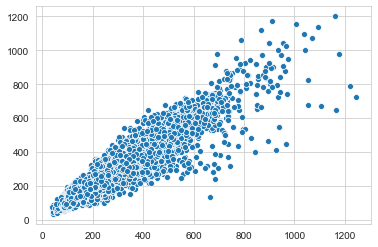

In [169]:
sns.scatterplot(test_actuals_inverted, test_forecasts_inverted)

In [181]:
#Future Trends

In [134]:
len(df_supervised_test_data_X_scaled)

5483

In [135]:
#df_supervised_test_data_X_scaled[5482]

In [184]:
#df_supervised_test_data_Y_scaled[5482]

In [185]:
#df_supervised_test_data_X_scaled[5482][0]

In [186]:
#list(df_supervised_test_data_Y_scaled[5482])

In [187]:
#np.append(list(df_supervised_test_data_X_scaled[5482][0]), list(df_supervised_test_data_Y_scaled[5482]))

In [188]:
#np.append(list(df_supervised_test_data_X_scaled[5482][0]), list(df_supervised_test_data_Y_scaled[5482]))[1:]

In [136]:
df_supervised_test_data_X_scaled

array([[[0.54853273],
        [0.48306998],
        [0.48306998],
        [0.51015801]],

       [[0.48306998],
        [0.48306998],
        [0.51015801],
        [0.49435666]],

       [[0.48306998],
        [0.51015801],
        [0.49435666],
        [0.49887133]],

       ...,

       [[0.46501129],
        [0.56659142],
        [0.71331828],
        [0.3476298 ]],

       [[0.56659142],
        [0.71331828],
        [0.3476298 ],
        [0.46726862]],

       [[0.71331828],
        [0.3476298 ],
        [0.46726862],
        [0.36343115]]])

In [137]:
df_supervised_test_data_X_scaled[5483-1][1:]

array([[0.3476298 ],
       [0.46726862],
       [0.36343115]])

In [138]:
df_supervised_test_data_Y_scaled[5483-1]

array([0.44920993])

In [140]:
np.append(df_supervised_test_data_X_scaled[5483-1][1:], df_supervised_test_data_Y_scaled[5483-1])

array([0.3476298 , 0.46726862, 0.36343115, 0.44920993])

In [141]:
print(n_lag, n_future_seq)

4 1


In [145]:
test_forecasts_inverted[5480:]

[array([745.5661869]), array([694.523839]), array([587.21127701])]

In [262]:
#Predict for next 3 days
future_forcasts = []
future_forcasts_scaled = []
curr_input = []
last_forcasted_value = 0
#5112
for i in range(0, 5112, 1):
    last_input = []
    last_forecast = []
    #print('iter#',i)
    if(len(curr_input) == 0):
        last_input = df_supervised_test_data_X_scaled[len(df_supervised_test_data_X_scaled) -1][1:]
        last_forecast = df_supervised_test_data_Y_scaled[len(df_supervised_test_data_X_scaled) -1]
        last_forcasted_value = test_forecasts_inverted[-1]
    
    else:
        #print('else curr_input:',curr_input)
        last_input = curr_input[1:]
        last_forecast = future_forcasts_scaled[i-1]
        #last_forcasted_value = future_forcasts[i-1]
    
    #print('last_input:', last_input)
    #print('last_forecast:', last_forecast)
    
    curr_input = np.append(last_input, last_forecast)
    #print('curr_input:',curr_input)
     
    curr_input_final = curr_input.reshape(1,n_lag,n_future_seq) 
    #print('curr_input_final reshaped:',curr_input_final)
    
    # make forecast
    new_forecast = model.predict(curr_input_final, batch_size=1)
    #print('new_forecast:',new_forecast)
    future_forcasts_scaled.append(new_forecast)
    #re-transform forcast
    new_forecast = scaler_output.inverse_transform(new_forecast)
    
    print('new forcasted value:', new_forecast, '; last_forcasted_value:',last_forcasted_value)
    future_forcasts.append((new_forecast + last_forcasted_value))
    
print('All forcast:', future_forcasts)

new forcasted value: [[-4.659053]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[-1.4008257]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.205132]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.053122]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.99457]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.218992]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.1203294]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.2217095]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[0.5490674]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[-0.00379753]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.2844955]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.6739287]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.379956]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.980517]] ; las

new forcasted value: [[10.781425]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.02398]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.248306]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.3691735]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.724991]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.0488105]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.3987229]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.24822]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.842286]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.014038]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.427283]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.16044]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.819285]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.0781965]] ; last_forca

new forcasted value: [[6.6278353]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.9200702]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1548524]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4070668]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.098346]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.5711083]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.752682]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.272867]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.179716]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.008714]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.338443]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.4916825]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4812691]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4829016]] ; last

new forcasted value: [[10.915878]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.95104]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.0345182]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.4820135]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.9214334]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4050072]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4661655]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.203135]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.346528]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.609477]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.110324]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.555078]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.7377324]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.004988]] ; last_fo

new forcasted value: [[8.240064]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.55297]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.129652]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.642636]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.847946]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.091332]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.250121]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4225929]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.982904]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.3456106]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.527238]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.132394]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.183202]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.159855]] ; last_forc

new forcasted value: [[1.5736815]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6018819]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.4151034]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.500036]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.416505]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.059521]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.713195]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.500996]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.5623465]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.155966]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7597829]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4510045]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.821575]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.731021]] ; last_fo

new forcasted value: [[2.1656256]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.695422]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.873828]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.345587]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.172904]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.922845]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.218565]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.391397]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4222808]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4649991]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.8130679]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.9771574]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.1409345]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.877323]] ; last_fo

new forcasted value: [[2.552404]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5063491]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7117789]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.727526]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.8648453]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.684356]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.12828]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.541458]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.17685]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.2442737]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.9465756]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6633524]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5102042]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.0948653]] ; last_fo

new forcasted value: [[5.8174706]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.876578]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.862119]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.963778]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.075407]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.1720347]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.580715]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.9725533]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.3999903]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.3732734]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.053472]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.210649]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.537022]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.134405]] ; last_f

new forcasted value: [[2.750546]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5803883]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5933795]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.3881705]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.467505]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.391896]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.052128]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.727242]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.529302]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.5909696]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.1752417]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.768919]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4467797]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.798286]] ; last_fo

new forcasted value: [[10.327473]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.174963]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.944814]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.2488775]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.416587]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4370675]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4693823]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.800552]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.9477425]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.1090374]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.855407]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.159385]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.411335]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.9532537]] ; last_

new forcasted value: [[4.5498786]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.7318754]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.260088]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.1806135]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.023183]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.358933]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.509004]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4915671]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4861758]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7566671]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8414893]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.9924335]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.774555]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.146129]] ; las

new forcasted value: [[4.591176]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.7724333]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.284908]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.178871]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.99493]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.319009]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.4753113]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.471605]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4798386]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.772246]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8798292]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.03484]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.804129]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.151252]] ; last_forca

new forcasted value: [[5.3850117]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.508019]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.691754]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.074836]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.416927]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.568477]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8747594]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1299262]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4042151]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1312993]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.632684]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.812991]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.309306]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.176759]] ; last_f

new forcasted value: [[6.1968026]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.182822]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.982736]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.835925]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.761454]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.830937]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.3391101]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.8490841]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4191074]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.6122901]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.4279985]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.545673]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.7102375]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.065541]] ; last

new forcasted value: [[7.3491106]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.50066]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.486603]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4845915]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7604166]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8508894]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.00289]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.781843]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.147396]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.469319]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.051057]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.125241]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.8702128]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6300822]] ; last_forc

new forcasted value: [[6.7484527]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.0132794]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.2063947]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4146714]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.033707]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.4469]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.62953]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.196927]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.183096]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.092681]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.458955]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.5943446]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.5422645]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5028636]] ; last_for

new forcasted value: [[5.8387527]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.894164]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.869617]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.957387]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.058139]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.152812]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.5667732]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.9652655]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4005184]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.3859477]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.0742793]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.2297125]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.547373]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.131342]] ; last

new forcasted value: [[1.5988717]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.405492]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.4885235]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.407739]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.056933]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.718265]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.51103]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.572592]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.1627786]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7630571]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4494202]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.813284]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.719403]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.794829]] ; last_forc

new forcasted value: [[3.9666483]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.1295276]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.869507]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.161444]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.399822]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.9341364]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.016664]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.8014545]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6011953]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5687702]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.3081636]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.369596]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.317223]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.02868]] ; last_f

new forcasted value: [[2.1551692]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4071724]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.0978706]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.5701575]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.751732]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.27234]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.179822]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.009347]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.3393936]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.4924746]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4817445]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4830072]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7642189]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8602896]] ; las

new forcasted value: [[5.9686646]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.00047]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.913449]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.916196]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.951885]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.035416]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.4827]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.9217503]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4049544]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4654791]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.202079]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.34563]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.609055]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.110536]] ; last_forcas

new forcasted value: [[6.6175904]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.50438]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.084553]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.660755]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.397806]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.4593678]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.0872607]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.7274106]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4674811]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.907074]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.8493147]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.902878]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.873314]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.954165]] ; last_f

new forcasted value: [[1.8600686]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.084308]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.255743]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.955006]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.1721115]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.327314]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.816371]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.9091434]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.7342806]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5738927]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6016178]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.4142585]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.4990854]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.415766]] ; last_

new forcasted value: [[9.367551]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.5093303]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8299239]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1054752]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4018387]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1650445]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.694366]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.872877]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.345006]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.172956]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.923584]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.2195153]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.392189]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.4227033]] ; last_f

new forcasted value: [[8.843995]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.9187064]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.4003167]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.8798194]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4120309]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.547968]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.330512]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.460121]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.667779]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.086137]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.458648]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.619069]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.9133105]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.15105]] ; last_forc

new forcasted value: [[9.598857]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.108846]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.600183]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.283473]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.347094]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.0133798]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6934011]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.488341]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.003399]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.9792266]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.009131]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.916829]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.91271]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.943119]] ; last_forc

new forcasted value: [[1.9145682]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.2033944]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.3809547]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.037865]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.179241]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.252061]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.6980243]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.8031015]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.6688492]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5484912]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6375284]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.5225186]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.6281524]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.512197]] ; la

new forcasted value: [[4.819842]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.9927554]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.415031]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.162711]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.835286]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.0995317]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.2934346]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.3654046]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.449209]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.8643461]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[4.0939198]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[7.2658825]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.961765]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.172798]] ; last_

new forcasted value: [[5.8027363]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.3196235]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.8393672]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4217479]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.633414]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.459473]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.573029]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.7235985]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[11.058359]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.359365]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.4996133]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.8226361]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.1015146]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.4015746]] ; last

new forcasted value: [[11.129758]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.536547]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.168189]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.2360353]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[2.9412417]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.6610287]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[1.5121582]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[3.1023114]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[6.1091914]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[9.113483]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.957229]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[10.867928]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[8.835071]] ; last_forcasted_value: [587.21127701]
new forcasted value: [[5.909148]] ; last_

new forcasted value: [[10.118452]] ; last_forcasted_value: [587.21127701]
All forcast: [array([[582.55222416]]), array([[585.81045127]]), array([[590.41640902]]), array([[596.26439857]]), array([[599.20584679]]), array([[595.43026924]]), array([[592.33160639]]), array([[589.4329865]]), array([[587.76034439]]), array([[587.20747948]]), array([[588.49577248]]), array([[591.88520575]]), array([[595.59123325]]), array([[598.1917944]]), array([[598.77766609]]), array([[597.00964928]]), array([[593.85210371]]), array([[590.86930537]]), array([[588.96921158]]), array([[588.11950326]]), array([[588.74836135]]), array([[591.35800648]]), array([[594.77484798]]), array([[597.51044369]]), array([[598.58226967]]), array([[597.45858479]]), array([[594.70339632]]), array([[591.71647882]]), array([[589.59743595]]), array([[588.51895595]]), array([[588.70363152]]), array([[590.77065682]]), array([[594.00577974]]), array([[596.90957451]]), array([[598.41180038]]), array([[597.83759975]]), array([[595.43

In [263]:
forcasts = [np.ceil(f.flatten()[0]) for f in future_forcasts]

In [264]:
max(forcasts)

600.0

In [265]:
df.tail()

,Count
18283,868
18284,732
18285,702
18286,580
18287,534


In [266]:
future_forcasts[1]

array([[585.81045127]])

In [267]:
future_forcasts[0].flatten()

array([582.55222416])

In [268]:
forcasts = [np.ceil(f.flatten()[0]) for f in future_forcasts]

In [269]:
#dict = {'future_forcasts': future_forcasts}
dict = {'Count': forcasts}
forcastDF = pd.DataFrame(dict)

In [270]:
forcastDF.head()

,Count
0,583.0
1,586.0
2,591.0
3,597.0
4,600.0


In [271]:
forcastDF.index+=18288

In [272]:
forcastDF.head()

,Count
18288,583.0
18289,586.0
18290,591.0
18291,597.0
18292,600.0


In [273]:
df.head()

,Count
0,8
1,2
2,6
3,2
4,2


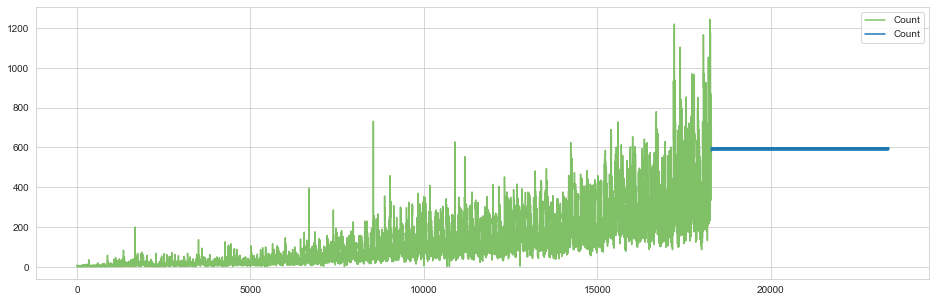

In [274]:
plt.figure(figsize=(16,5))
sns.lineplot(data=df, palette='summer')
sns.lineplot(data=forcastDF)

In [214]:
forcastDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 1 columns):
Count    5112 non-null float64
dtypes: float64(1)
memory usage: 40.0 KB


In [215]:
forcastDF.to_csv('forcasts_5feb.v2.csv')

In [ ]:
#Some other Reference:
#https://github.com/sagar3122/Time-Series